In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib notebook
%pylab


Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import anndata

In [3]:
df = pd.read_table("data/csv/sc_dropseq.count.csv.gz", compression="gzip", sep=",")

In [4]:
df.head()

,CELL_000001,CELL_000002,CELL_000003,CELL_000004,CELL_000005,CELL_000006,CELL_000007,CELL_000008,CELL_000009,CELL_000010,...,CELL_000228,CELL_000229,CELL_000230,CELL_000231,CELL_000233,CELL_000237,CELL_000238,CELL_000246,CELL_000249,CELL_000302
ENSG00000223849,0,0,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000225355,0,0,1,2,5,3,4,0,3,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000135093,0,0,0,0,3,2,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
ENSG00000183579,0,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000138363,4,14,22,13,7,5,10,6,7,10,...,0,0,0,1,3,0,2,3,0,0


In [5]:
df.shape

(15127, 225)

##### Qui in pratica cambio tutti i nomi del ciclo cellulare in ensg ID in più divido quelli della fase s e g2 perchè siccome alcuni possono essere tolti successivamente, non so la posizione nel momento in cui sono analizzati

In [6]:
nomi=pd.read_csv('nomi_geni.txt.gz', compression= 'gzip')
cell_cycle_genes = [x.strip() for x in open('regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


##### qui faccio il cambio di nome

In [7]:
ensg_s_genes =[nomi.loc[idx, "Gene stable ID"] for idx in nomi.index if nomi.loc[idx, "Gene name"] in s_genes]
ensg_g2m_genes =[nomi.loc[idx, "Gene stable ID"] for idx in nomi.index if nomi.loc[idx, "Gene name"] in g2m_genes]

##### lo stesso vale per i geni mitocondriali

In [8]:
adata = anndata.AnnData(df.T)#.values.T, obs=df.columns, var=df.index)
mito_genes = [nomi.loc[idx, "Gene stable ID"] for idx in nomi.index if nomi.loc[idx, "Gene name"].startswith("MT-") and 
             nomi.loc[idx, "Gene stable ID"] in adata.var_names]

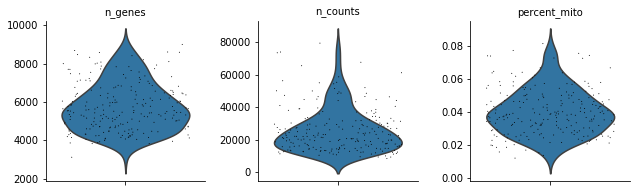

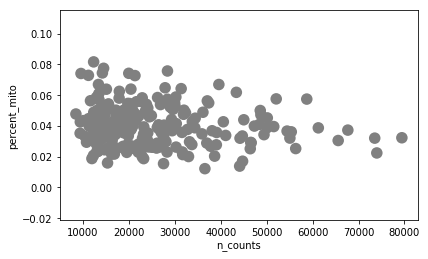

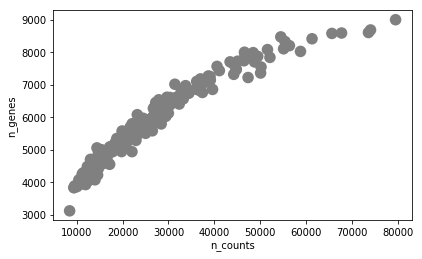

In [9]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=3)

 
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)


np.sum(adata[:, mito_genes].X, axis=1)

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)


sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')



adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


In [11]:
sc.tl.score_genes_cell_cycle(adata, s_genes=ensg_s_genes, g2m_genes=ensg_g2m_genes)


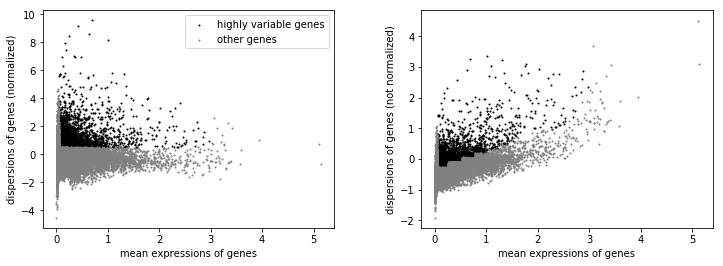

In [12]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [13]:
adata = adata[:, adata.var['highly_variable']]


In [14]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score','n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10) #i geni con una varianza più alta di 10 gli viene attribuita varianza uguale a 10

Trying to set attribute `.obs` of view, making a copy.
... storing 'phase' as categorical


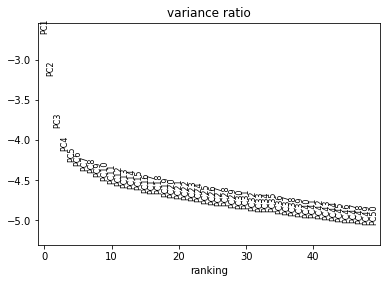

In [15]:
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)




In [16]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [17]:
sc.tl.umap(adata) 

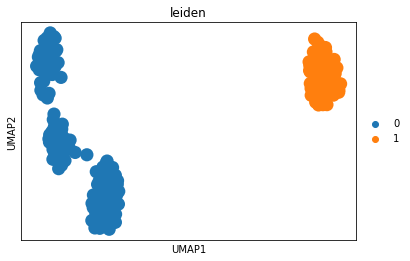

In [18]:
sc.tl.leiden(adata, resolution=0.05)
sc.pl.umap(adata, color="leiden")

In [19]:

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

##### ho creato un database che tiene conto dei geni che hanno una differenza di espressione significativa

In [20]:
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [24]:
for x in nomi.loc[df_significativo.loc[:,'2'].values, "Gene name"]:
    print(x)

SyntaxError: invalid syntax (<ipython-input-24-560fec38f495>, line 1)

In [ ]:
pwd

##### ora voglio dare i nomi ai miei gruppi separati di cellule e lo faccio attraverso il metadata con le cell annotation

In [21]:
cell_annotation= pd.read_table('data/csv/sc_dropseq.metadata.csv.gz', compression="gzip", sep=",", index_col=0)

In [22]:
cell_annotation.head()

,unaligned,aligned_unmapped,mapped_to_exon,mapped_to_intron,ambiguous_mapping,mapped_to_ERCC,mapped_to_MT,number_of_genes,total_count_per_cell,non_mt_percent,non_ribo_percent,outliers,cell_line,cell_line_demuxlet,demuxlet_cls
CELL_000001,101619,5913,254630,64711,6942,0,7566,9284,74261,0.848023,0.895463,False,H1975,H1975,SNG
CELL_000002,95759,10881,234950,86606,5960,0,7864,9255,68421,0.857982,0.899124,False,HCC827,HCC827,SNG
CELL_000003,92448,6336,251846,29568,6869,0,7975,9650,80134,0.839781,0.893578,False,HCC827,HCC827,SNG
CELL_000004,92454,6197,235800,27495,6058,0,4888,9257,74611,0.852180,0.883435,False,HCC827,HCC827,SNG
CELL_000005,74750,6194,218966,29425,5872,0,6211,9125,66161,0.839105,0.898157,False,H1975,H1975,SNG


In [23]:
cell_annotation.columns

Index(['unaligned', 'aligned_unmapped', 'mapped_to_exon', 'mapped_to_intron',
       'ambiguous_mapping', 'mapped_to_ERCC', 'mapped_to_MT',
       'number_of_genes', 'total_count_per_cell', 'non_mt_percent',
       'non_ribo_percent', 'outliers', 'cell_line', 'cell_line_demuxlet',
       'demuxlet_cls'],
      dtype='object')

##### qui conosco le cell anotation per ogni celula e do quindi ad ogni cellula la sua annotaizone

In [24]:
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

In [25]:
adata.obs.loc[:, "cell_line_demuxlet"] = cell_annotation.loc[adata.obs_names, "cell_line_demuxlet"]
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line', 'cell_line_demuxlet'],
      dtype='object')

... storing 'cell_line' as categorical
... storing 'cell_line_demuxlet' as categorical


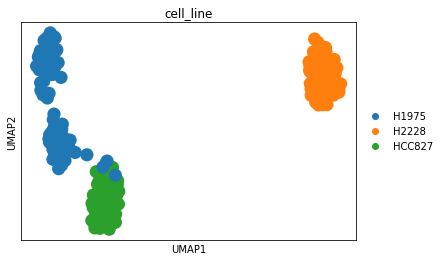

In [26]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line")

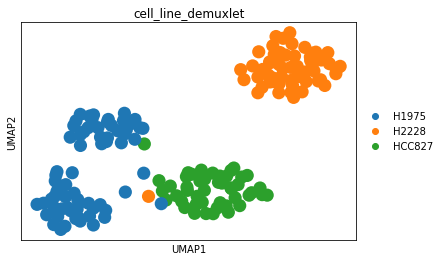

In [27]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line_demuxlet")

## grafi

In [32]:
import graph_tool.all as gt

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


In [33]:
g = gt.Graph(directed=False)

In [34]:
adata.uns['neighbors']

{'params': {'n_neighbors': 10,
  'method': 'umap',
  'metric': 'euclidean',
  'n_pcs': 40},
 'distances': <173x173 sparse matrix of type '<class 'numpy.float64'>'
 	with 1557 stored elements in Compressed Sparse Row format>,
 'connectivities': <173x173 sparse matrix of type '<class 'numpy.float64'>'
 	with 2568 stored elements in Compressed Sparse Row format>}

In [35]:
adj=adata.uns['neighbors']['connectivities'] #binario o si o no
w_adj=adata.uns['neighbors']['distances'] #pesato, mi da un valore in scala

In [36]:
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [37]:
w_adj = w_adj /w_adj.max()
w_adj = 1 - w_adj.todense()

In [38]:
wg = gt.Graph(directed=False)
edge_weights = wg.new_edge_property('double')
wg.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(w_adj,1))
nedges = len(nnz[0])
wg.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

##### nested SBM

In [50]:
n_state = gt.minimize_nested_blockmodel_dl(g)

In [51]:
levels = n_state.get_levels()
for s in levels:
    print(s)

<BlockState object with 6 blocks (6 nonempty), degree-corrected, for graph <Graph object, undirected, with 173 vertices and 1284 edges at 0x7f345fdfd150>, at 0x7f345fca1210>
<BlockState object with 3 blocks (3 nonempty), for graph <Graph object, undirected, with 6 vertices and 17 edges at 0x7f3444961390>, at 0x7f3447c25a90>
<BlockState object with 1 blocks (1 nonempty), for graph <Graph object, undirected, with 3 vertices and 6 edges at 0x7f34449922d0>, at 0x7f3447c1dc90>


In [52]:
state_ndc = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state_dc  = gt.minimize_nested_blockmodel_dl(g, deg_corr=True)

print("Non-degree-corrected DL:\t", state_ndc.entropy())
print("Degree-corrected DL:\t", state_dc.entropy())

Non-degree-corrected DL:	 3130.794035086801
Degree-corrected DL:	 3156.0354571473417


In [53]:
print(u"ln \u039b: ", state_dc.entropy() - state_ndc.entropy()) # sembra essere migliore la ndc

ln Λ:  25.24142206054057


## paga

In [39]:
sc.tl.leiden(adata, resolution=1.0)

In [40]:
sc.tl.paga(adata, groups='leiden')

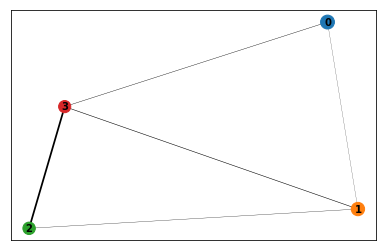

In [41]:
sc.pl.paga(adata, color=['leiden'])

In [42]:
adata.obs['cell_line'].cat.categories

Index(['H1975', 'H2228', 'HCC827'], dtype='object')

In [43]:
sc.tl.paga(adata, groups='cell_line')

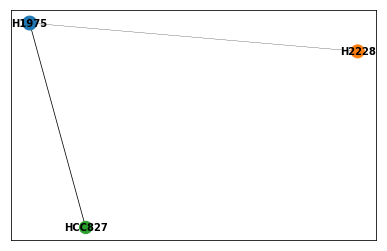

In [44]:
sc.pl.paga(adata, threshold=0.03)

In [45]:
sc.tl.paga(adata, groups='cell_line_demuxlet')

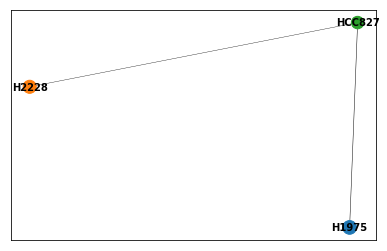

In [46]:
sc.pl.paga(adata, threshold=0.03)

In [47]:
sc.tl.draw_graph(adata, init_pos='paga')

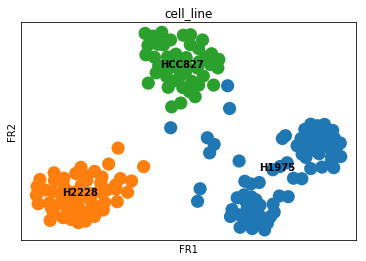

In [48]:
sc.pl.draw_graph(adata, color=['cell_line'], legend_loc='on data')

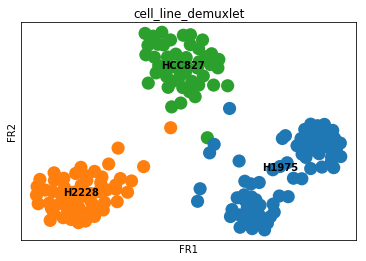

In [49]:
sc.pl.draw_graph(adata, color=['cell_line_demuxlet'], legend_loc='on data')

# paragone sbm vs leiden
### Leiden

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [28]:
sc.tl.umap(adata) 

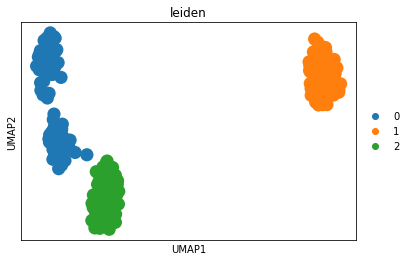

In [50]:
sc.tl.leiden(adata, resolution=0.056)
sc.pl.umap(adata, color="leiden") 

In [51]:
resolutions = np.arange(0, 1, 0.005)
leiden_clusters = pd.DataFrame(index=adata.obs_names, columns=resolutions)

In [52]:
for r in resolutions:
    sc.tl.leiden(adata, resolution=r)
    leiden_clusters.loc[:, r] = adata.obs.leiden

### SBM

In [32]:
import graph_tool.all as gt
g = gt.Graph(directed=False)

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


In [33]:
adj=adata.uns['neighbors']['connectivities']
w_adj=adata.uns['neighbors']['distances']

In [34]:
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [35]:
w_adj = w_adj /w_adj.max()
w_adj = 1 - w_adj.todense()

In [36]:
wg = gt.Graph(directed=False)
edge_weights = wg.new_edge_property('double')
wg.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(w_adj,1))
nedges = len(nnz[0])
wg.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [43]:
n_state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)

In [44]:
n_state

<NestedBlockState object, with base <BlockState object with 14 blocks (14 nonempty), for graph <Graph object, undirected, with 173 vertices and 1280 edges at 0x7ff10b00eb10>, at 0x7ff108ce8e50>, and 4 levels of sizes [(173, 14), (14, 4), (4, 2), (2, 1)] at 0x7ff108e1d6d0>

In [45]:
n_state.print_summary()

l: 0, N: 173, B: 14
l: 1, N: 14, B: 4
l: 2, N: 4, B: 2
l: 3, N: 2, B: 1


In [46]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(n_state.project_level(1).get_blocks()))

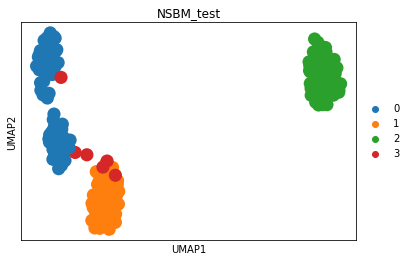

In [47]:
sc.pl.umap(adata, color="NSBM_test")

In [48]:
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

cell_line,H1975,H2228,HCC827
NSBM_test,,,
0,66,0,0
1,0,0,45
2,0,56,0
3,6,0,0


### mi leiden vs nsbm

In [61]:
import sklearn.metrics

In [62]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, adata.obs.cell_line)

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8895756628856932

In [63]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, leiden_clusters.loc[:,0.05])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9340183822260338

In [64]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, leiden_clusters.loc[:,0.05])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9329869027376525

In [65]:
MI_= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, leiden_clusters.loc[:,x]) for x in resolutions]
RS= [sklearn.metrics.adjusted_rand_score( adata.obs.NSBM_test, leiden_clusters.loc[:,x]) for x in resolutions]
MI_cl= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, leiden_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

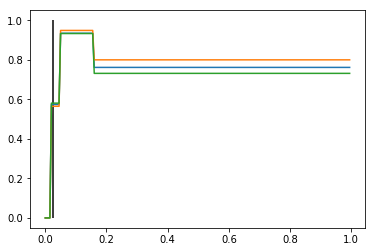

In [68]:
plot(resolutions, MI_)
plot(resolutions, RS)
plot(resolutions, MI_cl)
vlines(0.025, 0, 1)

In [70]:
NSBM = np.array([list(n_state.project_level(x).get_blocks()) for x in range(3)])
NSBM

array([[0, 1, 1, 1, 2, 0, 3, 2, 0, 2, 3, 0, 1, 1, 1, 3, 4, 5, 3, 2, 6, 0,
        4, 1, 7, 0, 2, 3, 5, 7, 3, 3, 5, 7, 5, 3, 4, 2, 1, 5, 3, 3, 1, 4,
        2, 7, 2, 5, 0, 4, 7, 0, 5, 3, 6, 3, 7, 4, 7, 2, 0, 5, 5, 5, 5, 8,
        6, 6, 3, 5, 5, 5, 6, 5, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 2, 5, 4, 7,
        2, 4, 6, 4, 6, 4, 4, 4, 3, 5, 4, 4, 5, 5, 7, 5, 3, 6, 4, 7, 0, 5,
        6, 7, 6, 4, 7, 7, 5, 4, 4, 6, 7, 4, 6, 4, 5, 8, 4, 7, 4, 6, 4, 5,
        5, 4, 4, 4, 4, 4, 5, 4, 7, 6, 5, 5, 6, 4, 4, 6, 6, 4, 8, 8, 7, 5,
        4, 5, 7, 7, 4, 4, 5, 7, 7, 8, 6, 6, 6, 7, 6, 7, 4, 7, 5],
       [0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 2, 2, 1, 2, 0, 0, 0,
        2, 1, 0, 0, 0, 2, 1, 0, 2, 2, 1, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2,
        0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 2, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 2, 0,
        0, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0, 0, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 0,

In [71]:
MI_nsbm = [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, NSBM[x]) for x in range(3)]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


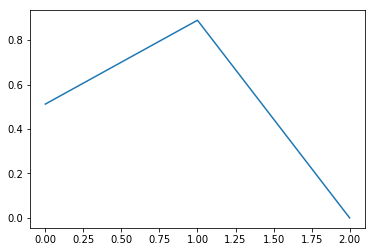

In [72]:
plot(range(3), MI_nsbm)

### df leiden vs nsbm

In [73]:
SBM_gruppi=pd.Categorical(adata.obs.NSBM_test).unique()
SBM_gruppi

[0, 1, 2]
Categories (3, int64): [0, 1, 2]

In [74]:
leiden_vs_SBM=pd.DataFrame(index=resolutions, columns=SBM_gruppi)

In [75]:
MI_leiden_NSBM0= [sklearn.metrics.adjusted_mutual_info_score( NSBM[0], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM1= [sklearn.metrics.adjusted_mutual_info_score( NSBM[1], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM2= [sklearn.metrics.adjusted_mutual_info_score( NSBM[2], leiden_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

In [76]:
leiden_vs_SBM.loc[:,0]=MI_leiden_NSBM0
leiden_vs_SBM.loc[:,1]=MI_leiden_NSBM1
leiden_vs_SBM.loc[:,2]=MI_leiden_NSBM2

In [77]:
leiden_vs_SBM.head()

,0,1,2
0.000,2.85776e-16,-4.31618e-17,1
0.005,2.85776e-16,-4.31618e-17,1
0.010,2.85776e-16,-4.31618e-17,1
0.015,2.85776e-16,-4.31618e-17,1
0.020,0.304782,0.573857,2.32389e-15


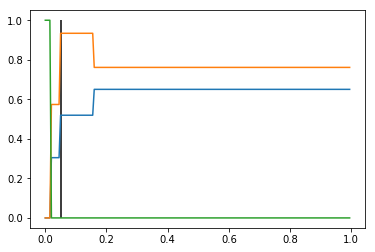

In [79]:
plot(leiden_vs_SBM)
vlines(0.05, 0, 1)

# paragone louvain vs nsbm

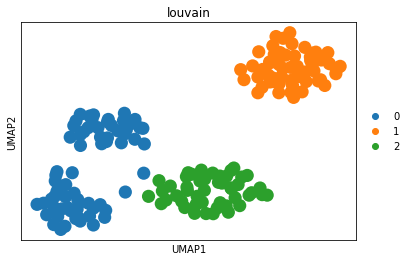

In [88]:
sc.tl.louvain(adata, resolution=0.057)
sc.pl.umap(adata, color="louvain") 

In [89]:
resolutions= np.arange(0, 1, 0.005)
louvain_clusters= pd.DataFrame(index=adata.obs_names, columns=resolutions)

In [90]:
for r in resolutions:
    sc.tl.louvain(adata, resolution=r)
    louvain_clusters.loc[:, r] = adata.obs.louvain

In [94]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, louvain_clusters.loc[:,0.06])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9340183822260338

In [96]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, louvain_clusters.loc[:,0.06])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9329869027376525

In [97]:
MI_= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, louvain_clusters.loc[:,x]) for x in resolutions]
RS= [sklearn.metrics.adjusted_rand_score( adata.obs.NSBM_test, louvain_clusters.loc[:,x]) for x in resolutions]
MI_cl= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, louvain_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

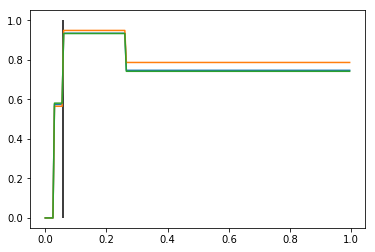

In [98]:
plot(resolutions, MI_)
plot(resolutions, RS)
plot(resolutions, MI_cl) #verde
vlines(0.057, 0, 1)

In [99]:
louvain_vs_SBM=pd.DataFrame(index=resolutions, columns=SBM_gruppi)

In [100]:
MI_louvain_NSBM0= [sklearn.metrics.adjusted_mutual_info_score( NSBM[0], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM1= [sklearn.metrics.adjusted_mutual_info_score( NSBM[1], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM2= [sklearn.metrics.adjusted_mutual_info_score( NSBM[2], louvain_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

In [101]:
louvain_vs_SBM.loc[:,0]=MI_louvain_NSBM0
louvain_vs_SBM.loc[:,1]=MI_louvain_NSBM1
louvain_vs_SBM.loc[:,2]=MI_louvain_NSBM2

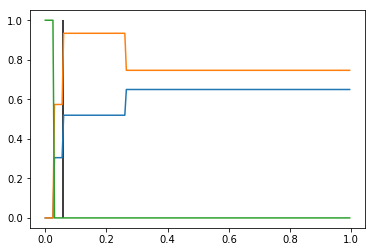

In [102]:
plot(louvain_vs_SBM)
vlines(0.057, 0, 1)